In [1]:
import joblib
import pickle
import base64
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
import matplotlib
from sqlalchemy import create_engine
import mysql.connector


In [2]:
db_config = {
    'host': 'localhost',
    'user': 'root',
    'password': 'root',
    'database': 'aaa'
}


connection = mysql.connector.connect(**db_config)

query = "SELECT * FROM employee_attrition"
df = pd.read_sql_query(query, connection)

C:\Users\JHING\AppData\Local\Temp\ipykernel_19892\2691225427.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


In [3]:
df.shape

(5000, 13)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      5000 non-null   int64  
 1   department              5000 non-null   object 
 2   employee_id             5000 non-null   int64  
 3   age                     5000 non-null   int64  
 4   age_when_joined         5000 non-null   int64  
 5   years_in_the_company    5000 non-null   int64  
 6   salary                  5000 non-null   float64
 7   annual_bonus            5000 non-null   float64
 8   prior_years_experience  5000 non-null   int64  
 9   full_time               5000 non-null   float64
 10  part_time               5000 non-null   float64
 11  contractor              5000 non-null   float64
 12  attrition               5000 non-null   int64  
dtypes: float64(5), int64(7), object(1)
memory usage: 507.9+ KB


In [5]:
df.drop_duplicates(inplace=True)

In [6]:
pos_count = len(df[df['attrition'] == 1])
neg_count = len(df[df['attrition'] == 0])
total_count = len(df['attrition'])

pos_count_percentage = (pos_count / total_count) * 100
neg_count_percentage = (neg_count / total_count) * 100
print(f"pos_count: {pos_count}")
print(f"neg_count: {neg_count}")
print(f"total: {total_count}")


pos_count: 207
neg_count: 4793
total: 5000


(-1.0999996318726954,
 1.099999914454108,
 -1.1049574984284725,
 1.204113142676508)

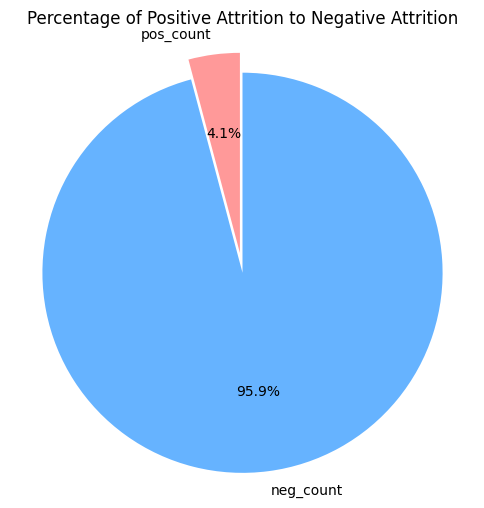

In [7]:
labels = ['pos_count', 'neg_count']
sizes = [pos_count_percentage, neg_count_percentage]
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)

plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Percentage of Positive Attrition to Negative Attrition')
plt.axis('equal')

<Axes: xlabel='employee_id'>

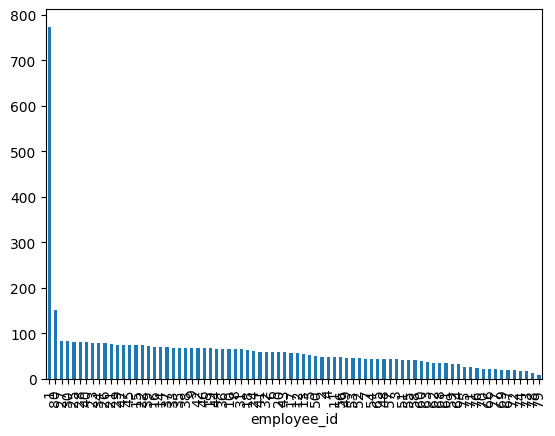

In [8]:
df['employee_id'].value_counts().plot.bar()

# Data PreProcessing

1=Spam
0=Ham

# Vectorize Text

In [9]:
df.head()

,id,department,employee_id,age,age_when_joined,years_in_the_company,salary,annual_bonus,prior_years_experience,full_time,part_time,contractor,attrition
0,1,BigData,16,41,38,3,68074.97,17664.10,3,0.000000,0.000000,1.000000,0
1,2,AI,56,44,42,2,49092.15,21551.14,2,0.000000,0.184991,1.000000,0
2,3,Support,59,41,40,1,40000.00,23698.88,2,0.000000,0.919887,0.662706,0
3,4,Design,40,39,32,7,108192.47,21570.93,1,0.930396,0.546206,0.000000,0
4,5,Search Engine,47,30,22,9,71291.19,21565.51,2,0.525432,0.938412,0.000000,0


In [10]:
print("DataFrame Columns:", df.columns)


DataFrame Columns: Index(['id', 'department', 'employee_id', 'age', 'age_when_joined',
       'years_in_the_company', 'salary', 'annual_bonus',
       'prior_years_experience', 'full_time', 'part_time', 'contractor',
       'attrition'],
      dtype='object')


# DATA SPLITTING

In [11]:
encoder = OneHotEncoder()
categorical_features = ['department', 'full_time', 'part_time', 'contractor']
encoded_categorical = encoder.fit_transform(df[categorical_features]).toarray()
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out())


# RESAMPLING

In [12]:
numerical_features = ['age', 'age_when_joined', 'years_in_the_company', 'salary', 'annual_bonus', 'prior_years_experience']
scaler = MinMaxScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])


In [13]:
df_processed = pd.concat([df[numerical_features], encoded_categorical_df], axis=1)


In [14]:
X = df_processed
y = df['attrition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)


In [16]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])


In [17]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('model.h5', save_best_only=True)

history = model.fit(X_train_resampled, y_train_resampled, epochs=20, batch_size=65,
                    validation_data=(X_test, y_test), callbacks=[early_stopping, model_checkpoint])


Epoch 1/20


119/119 [==============================] - ETA: 0s - loss: 0.3286 - accuracy: 0.8884

c:\Users\JHING\Desktop\ultra final\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


119/119 [==============================] - 19s 96ms/step - loss: 0.3286 - accuracy: 0.8884 - val_loss: 0.0913 - val_accuracy: 0.9620
Epoch 2/20
119/119 [==============================] - 8s 67ms/step - loss: 0.0552 - accuracy: 0.9880 - val_loss: 0.0441 - val_accuracy: 0.9810
Epoch 3/20
119/119 [==============================] - 7s 60ms/step - loss: 0.0287 - accuracy: 0.9934 - val_loss: 0.0300 - val_accuracy: 0.9900
Epoch 4/20
119/119 [==============================] - 9s 79ms/step - loss: 0.0207 - accuracy: 0.9960 - val_loss: 0.0219 - val_accuracy: 0.9920
Epoch 5/20
119/119 [==============================] - 8s 68ms/step - loss: 0.0142 - accuracy: 0.9971 - val_loss: 0.0210 - val_accuracy: 0.9910
Epoch 6/20
119/119 [==============================] - 8s 64ms/step - loss: 0.0105 - accuracy: 0.9980 - val_loss: 0.0196 - val_accuracy: 0.9930
Epoch 7/20
119/119 [==============================] - 7s 62ms/step - loss: 0.0094 - accuracy: 0.9980 - val_loss: 0.0127 - val_accuracy: 0.9960
Epoch 8/2

In [19]:
model.evaluate(X_test, y_test)


32/32 [==============================] - 1s 16ms/step - loss: 9.6609e-04 - accuracy: 1.0000


[0.000966086401604116, 1.0]

In [20]:
with open('training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)
